# Modeling Wins from Payroll and WAR (2000–2016)

This notebook builds interpretable statistical models to quantify how payroll and WAR
relate to team wins. We compare baseline payroll-only models to WAR-inclusive models and
evaluate predictive performance using train/test splits.


## Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm

df = pd.read_csv("../data/processed/team_wins_payroll_war_efficiency_2000_2016.csv")
df.shape, df. columns

((510, 12),
 Index(['yearID', 'teamID', 'name', 'W', 'payroll', 'Batting_WAR',
        'Pitching_WAR', 'Total_WAR', 'Dollars_per_Win', 'Dollars_per_WAR',
        'WAR_per_Million', 'Wins_per_100M'],
       dtype='object'))

In [2]:
df[["W", "payroll", "Total_WAR", "Batting_WAR", "Pitching_WAR"]].isna().sum()
df.describe()[["W", "payroll", "Total_WAR"]]

,W,payroll,Total_WAR
count,510.000000,5.100000e+02,510.000000
mean,80.964706,8.650195e+07,33.439137
std,11.365111,3.992242e+07,10.850965
min,43.000000,1.467150e+07,1.088333
25%,72.000000,5.907392e+07,25.208333
50%,82.000000,8.041048e+07,34.031667
75%,90.000000,1.040865e+08,41.587927
max,116.000000,2.319789e+08,69.028333


## Train/test split

In [3]:
RANDOM_STATE = 42

train_df, test_df = train_test_split(df, test_size=0.2,random_state=RANDOM_STATE)

train_df.shape, test_df.shape


((408, 12), (102, 12))

## Baseline Model A: Payroll to Wins

Fit OLS with statsmodels

In [4]:
train_df = train_df.copy()
test_df = test_df.copy()

train_df["log_payroll"] = np.log(train_df["payroll"])
test_df["log_payroll"] = np.log(test_df["payroll"])


Fit model

In [5]:
X_train = sm.add_constant(train_df[["log_payroll"]])
y_train = train_df["W"]

model_a = sm.OLS(y_train, X_train).fit()
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     59.74
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           8.58e-14
Time:                        14:44:59   Log-Likelihood:                -1549.9
No. Observations:                 408   AIC:                             3104.
Df Residuals:                     406   BIC:                             3112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -84.8780     21.485     -3.951      

Evaluate on test

In [7]:
X_test = sm.add_constant(test_df[["log_payroll"]])
y_test = test_df["W"]

pred_a = model_a.predict(X_test)

print("Model A (log payroll) MAE:", mean_absolute_error(y_test, pred_a))
print("Model A (log payroll) R^2:", r2_score(y_test, pred_a))

Model A (log payroll) MAE: 8.20530666467834
Model A (log payroll) R^2: 0.09127832654428447


### Model A: Payroll Only

A baseline regression using payroll alone explains relatively little variation in team wins.
While payroll is statistically significant, the model exhibits high prediction error, indicating
that spending alone is an insufficient predictor of competitive success.


## Model B: WAR to Wins

In [ ]:
X_train = sm.add_constant(train_df[["Total_WAR"]])
model_b = sm.OLS(y_train, X_train).fit()
print(model_b.summary())

X_test = sm.add_constant(test_df[["Total_WAR"]])
pred_b = model_b.predict(X_test)

print("Model B (WAR) MAE:", mean_absolute_error(y_test, pred_b))
print("Model B (WAR) R^2:", r2_score(y_test, pred_b))

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2422.
Date:                Thu, 05 Feb 2026   Prob (F-statistic):          3.21e-173
Time:                        14:53:23   Log-Likelihood:                -1181.9
No. Observations:                 408   AIC:                             2368.
Df Residuals:                     406   BIC:                             2376.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.8463      0.691     70.669      0.0

### Model B: WAR Only

WAR explains the majority of variation in team wins, with an estimated coefficient close to
one win per WAR. This confirms WAR as a strong proxy for team performance and substantially
outperforms payroll-only models.


## Model C: Payroll + WAR to Wins

In [9]:
X_train = sm.add_constant(train_df[["log_payroll", "Total_WAR"]])
model_c = sm.OLS(y_train, X_train).fit()
print(model_c.summary())

X_test = sm.add_constant(test_df[["log_payroll", "Total_WAR"]])
pred_c = model_c.predict(X_test)

print("Model C (log payroll + WAR) MAE:", mean_absolute_error(y_test, pred_c))
print("Model C (log payroll + WAR) R^2:", r2_score(y_test, pred_c))


                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1224.
Date:                Thu, 05 Feb 2026   Prob (F-statistic):          1.96e-172
Time:                        14:58:04   Log-Likelihood:                -1179.6
No. Observations:                 408   AIC:                             2365.
Df Residuals:                     405   BIC:                             2377.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          29.4191      9.034      3.256      

### Model C: Payroll and WAR

Including both payroll and WAR reveals that WAR dominates the relationship with wins.
Once WAR is accounted for, payroll contributes only marginal explanatory power, supporting
the hypothesis that payroll impacts wins primarily through its ability to generate WAR.


## Model D: Batting WAR + Pitching WAR

In [10]:
X_train = sm.add_constant(train_df[["Batting_WAR", "Pitching_WAR", "log_payroll"]])
model_d = sm.OLS(y_train, X_train).fit()
print(model_d.summary())

X_test = sm.add_constant(test_df[["Batting_WAR", "Pitching_WAR", "log_payroll"]])
pred_d = model_d.predict(X_test)

print("Model D MAE:", mean_absolute_error(y_test, pred_d))
print("Model D R^2:", r2_score(y_test, pred_d))


                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     857.0
Date:                Thu, 05 Feb 2026   Prob (F-statistic):          1.05e-174
Time:                        14:58:50   Log-Likelihood:                -1170.6
No. Observations:                 408   AIC:                             2349.
Df Residuals:                     404   BIC:                             2365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.3307      8.848      3.315   

### Model D: Batting and Pitching WAR

Separating WAR into batting and pitching components further improves model performance.
Pitching WAR exhibits a slightly stronger marginal impact on wins, highlighting the importance
of run prevention in determining team success.


## Model Comparison Table

In [11]:
results = pd.DataFrame([
    {"Model": "A: log(payroll)", "MAE": mean_absolute_error(y_test, pred_a), "R2": r2_score(y_test, pred_a)},
    {"Model": "B: WAR", "MAE": mean_absolute_error(y_test, pred_b), "R2": r2_score(y_test, pred_b)},
    {"Model": "C: log(payroll)+WAR", "MAE": mean_absolute_error(y_test, pred_c), "R2": r2_score(y_test, pred_c)},
    {"Model": "D: log(payroll)+BatWAR+PitWAR", "MAE": mean_absolute_error(y_test, pred_d), "R2": r2_score(y_test, pred_d)},
]).sort_values("R2", ascending=False)

results


,Model,MAE,R2
3,D: log(payroll)+BatWAR+PitWAR,3.552462,0.822563
1,B: WAR,3.586535,0.809703
2,C: log(payroll)+WAR,3.633945,0.808043
0,A: log(payroll),8.205307,0.091278


### Model Comparison

Across all models, WAR-based specifications dramatically outperform payroll-only approaches.
Disaggregating WAR into batting and pitching components provides the strongest predictive
performance, reinforcing the central role of on-field value generation in determining wins.


## Diagnostics: predicted vs actual + residuals

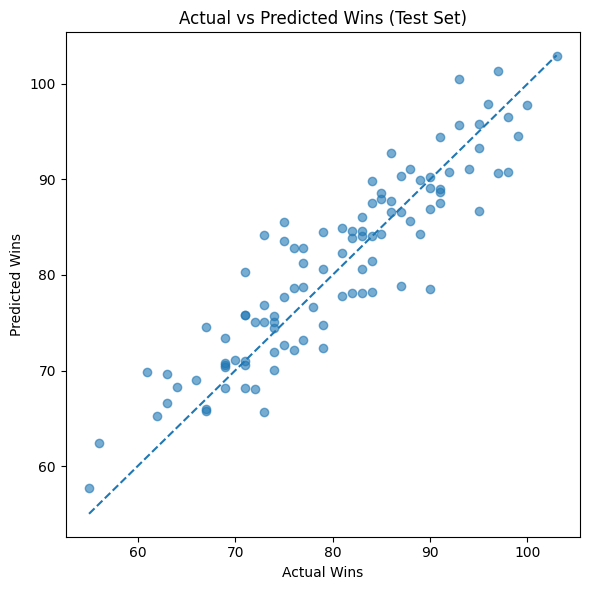

In [12]:
best_pred = pred_d

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Actual vs Predicted Wins (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.tight_layout()
plt.savefig("../visuals/model_actual_vs_pred.png", dpi=300)
plt.show()


The predicted-versus-actual wins plot shows strong alignment with the 45-degree reference
line, indicating good model calibration. Predictions remain accurate across a wide range
of win totals, suggesting that the model generalizes well to unseen team-seasons.


## Residual Plot

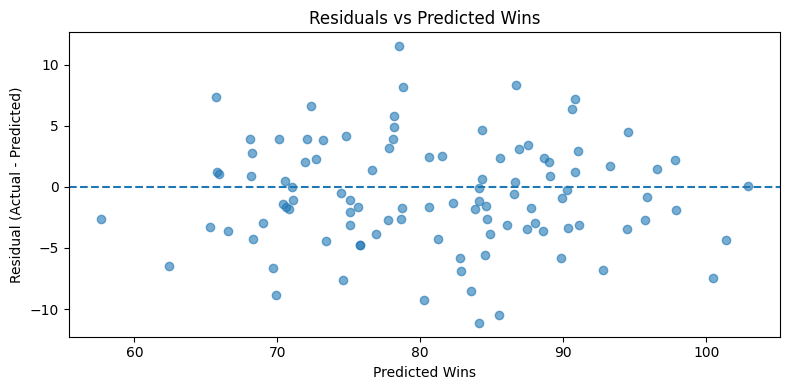

In [13]:
resid = y_test - best_pred

plt.figure(figsize=(8,4))
plt.scatter(best_pred, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Wins")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted Wins")
plt.tight_layout()
plt.savefig("../visuals/model_residuals.png", dpi=300)
plt.show()


Residuals are centered around zero with no clear pattern across predicted win values,
indicating stable variance and no evidence of systematic model bias. This supports the
appropriateness of a linear modeling approach.


## Summary

Regression results confirm that payroll alone is a weak predictor of team wins.
WAR explains the majority of variation in on-field success, and disaggregating WAR
into batting and pitching components further improves predictive accuracy.

Model diagnostics indicate good calibration, stable residual variance, and strong
generalization performance. These results reinforce the conclusion that payroll
impacts wins primarily through its ability to generate on-field value.
